In [1]:
import tensorflow as tf
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Input, Dropout, Conv2DTranspose, concatenate, BatchNormalization, ReLU, LeakyReLU
from keras import Model
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
image_dir = [f"F:/SOC IMAGE SEGMENTATION/data/data{dir}/data{dir}/CameraRGB" for dir in ["A", "B", "C", "D", "E"]]
mask_dir = [f"F:/SOC IMAGE SEGMENTATION/data/data{dir}/data{dir}/CameraSeg" for dir in ["A", "B", "C", "D", "E"]]

image_paths = [f"{dir}/{image}" for dir in image_dir for image in os.listdir(dir)]
mask_paths = [f"{dir}/{image}" for dir in mask_dir for image in os.listdir(dir)]

total_images, total_masks = len(image_paths), len(mask_paths)
print(f"Total Images: {total_images}, Total Masks: {total_masks}")
print("Eg. of image: ", image_paths[0])
print("Eg. of mask:  ", mask_paths[0])


Total Images: 5000, Total Masks: 5000
Eg. of image:  F:/SOC IMAGE SEGMENTATION/data/dataA/dataA/CameraRGB/02_00_000.png
Eg. of mask:   F:/SOC IMAGE SEGMENTATION/data/dataA/dataA/CameraSeg/02_00_000.png


(np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5))

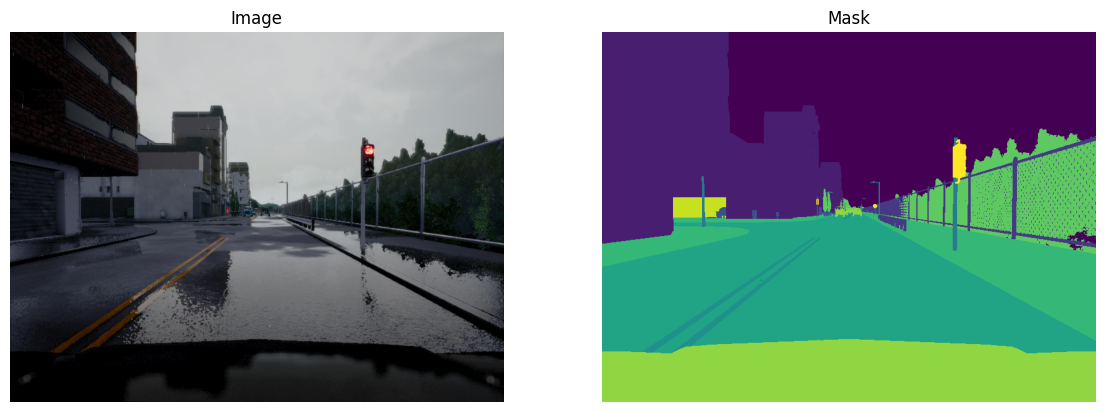

In [3]:
import imageio
N = 4

sample_img = imageio.v3.imread(image_paths[N])

sample_mask = imageio.v3.imread(mask_paths[N])
sample_mask = np.array([max(sample_mask[i, j]) for i in range(sample_mask.shape[0]) for j in range(sample_mask.shape[1])])
sample_mask = sample_mask.reshape(sample_img.shape[0], sample_img.shape[1])
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(sample_img)
arr[0].set_title("Image")
arr[0].axis("off")
arr[1].imshow(sample_mask)
arr[1].set_title( "Mask")
arr[1].axis("off")

In [4]:
from sklearn.model_selection import train_test_split
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size = 0.2, random_state = 42)
val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, test_size = 0.2, random_state = 42)

print("Train Size: ", len(train_image_paths))
print("Validation Size: ", len(val_image_paths))
print("Test Size: ", len(test_image_paths))

Train Size:  4000
Validation Size:  800
Test Size:  200


In [5]:
def read_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (192, 256), method = "nearest")
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 3)
    mask = tf.math.reduce_max(mask, axis = -1, keepdims = True)
    mask = tf.image.resize(mask, (192, 256), method = "nearest")
    
    return image, mask


def generate_dataset(image_paths, mask_paths, buffer_size, batch_size):
    image_list = tf.constant(image_paths)
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    
    return dataset


In [6]:

buffer_size = 1000
batch_size = 64

train_dataset = generate_dataset(train_image_paths, train_mask_paths, buffer_size, batch_size)
val_dataset = generate_dataset(val_image_paths, val_mask_paths, buffer_size, batch_size)
test_dataset = generate_dataset(test_image_paths, test_mask_paths, buffer_size, batch_size)

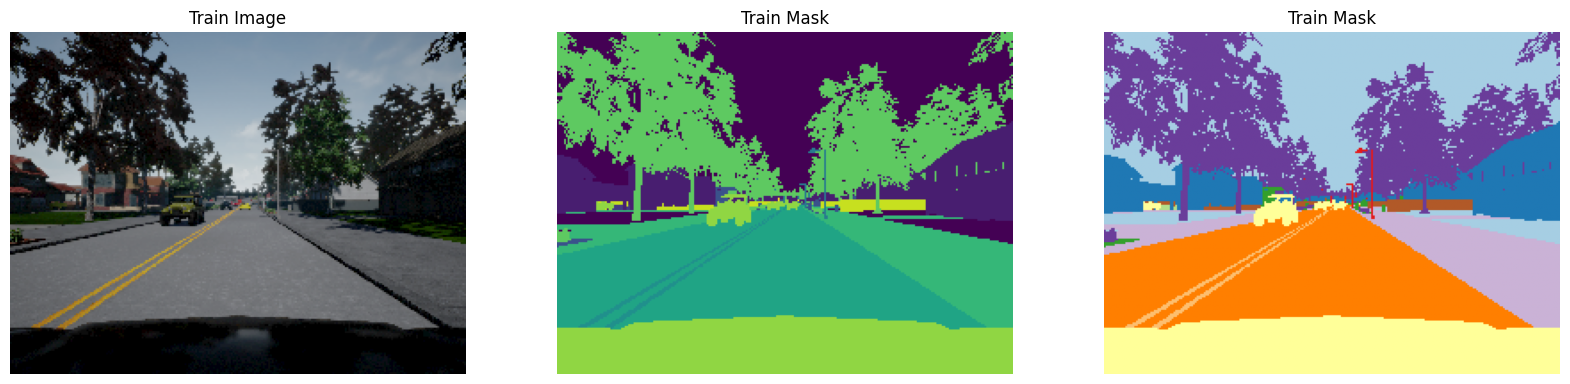

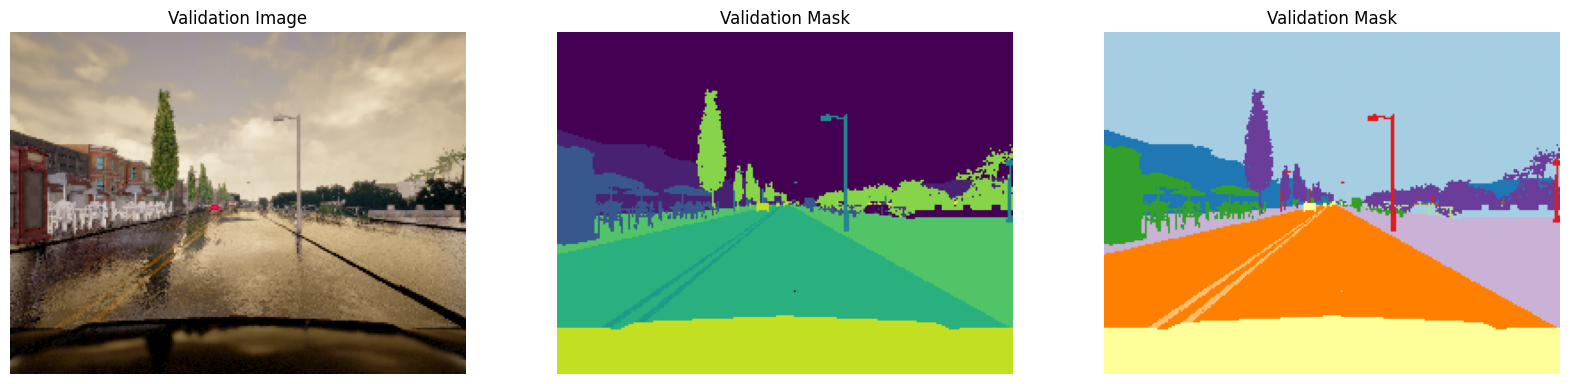

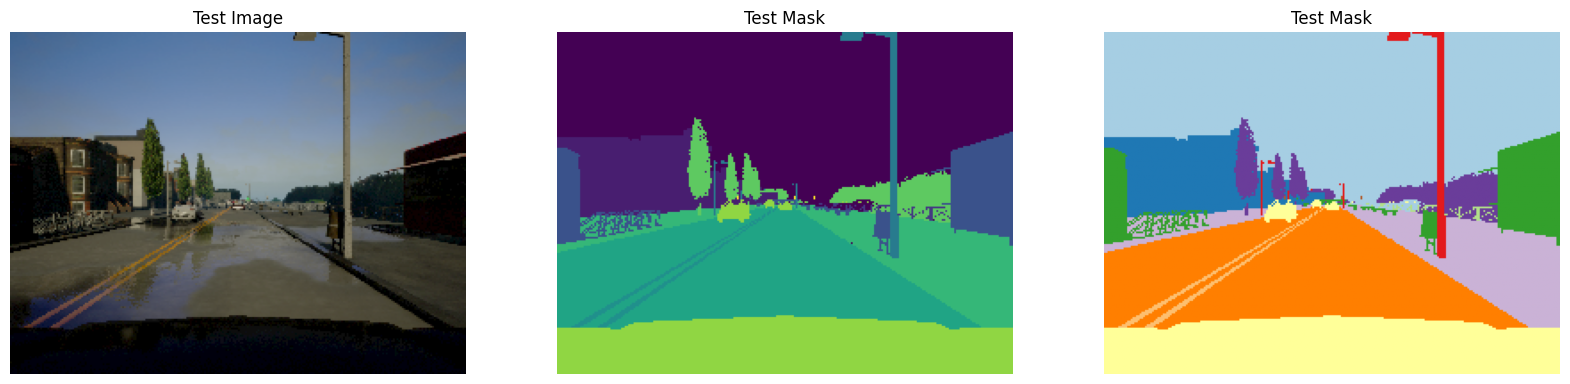

In [7]:
import random
for train_images, train_masks in train_dataset:
    break

for val_images, val_masks in val_dataset:
    break

for test_images, test_masks in test_dataset:
    break
    
for i in range(3):
    N = random.randint(0, batch_size-1)
    
    images = [train_images[N], val_images[N], test_images[N]]
    masks = [train_masks[N], val_masks[N], test_masks[N]]
    titles = ["Train Image", "Validation Image", "Test Image", "Train Mask", "Validation Mask", "Test Mask"]
    
    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(images[i])
    arr[0].set_title(titles[i])
    arr[0].axis("off")
    
    arr[1].imshow(masks[i])
    arr[1].set_title(titles[i+3])
    arr[1].axis("off")
    
    arr[2].imshow(masks[i], cmap = "Paired")
    arr[2].set_title(titles[i+3])
    arr[2].axis("off")


In [8]:
def conv_block(inputs = None, n_filters = 32, dropout = 0, max_pooling = True):
    layer = Conv2D(n_filters, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = LeakyReLU()(layer)
    
    layer = Conv2D(n_filters, 3, padding = 'same', kernel_initializer = 'he_normal')(layer)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = LeakyReLU()(layer)
    
    if dropout > 0:
        layer = Dropout(dropout)(layer)
    
    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2, 2))(layer)
    else:
        next_layer = layer
    
    skip_connection = layer
    
    return next_layer, skip_connection


In [9]:
def up_block(expansive_input, contractive_input, n_filters = 32):
    up = Conv2DTranspose(n_filters, 3, strides = (2, 2), padding = 'same')(expansive_input)
    merge = concatenate([up, contractive_input], axis = 3)
    
    layer = Conv2D(n_filters, 3, padding = 'same', kernel_initializer = 'he_normal')(merge)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = LeakyReLU()(layer)
    
    layer = Conv2D(n_filters, 3, padding = 'same', kernel_initializer = 'he_normal')(layer)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = LeakyReLU()(layer)
    
    return layer

In [10]:
def unet_model(input_size = (96, 128, 3), n_filters = 32, n_classes = 13):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout = 0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout = 0.3, max_pooling = False)
    
    ublock6 = up_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = up_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = up_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = up_block(ublock8, cblock1[1], n_filters)
    
    layer = Conv2D(n_filters, 3, padding = 'same', kernel_initializer = 'he_normal')(ublock9)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = LeakyReLU()(layer)
    
    layer = Conv2D(n_classes, 1, padding = 'same')(layer)
    layer = BatchNormalization(axis = 3)(layer, training = True)
    layer = LeakyReLU()(layer)
    
    model = Model(inputs = inputs, outputs = layer)
    return model

In [11]:
img_size = (192, 256, 3)
unet_model = unet_model(img_size)

unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 192, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 192, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 192, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 192, 256,  │      9,248 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 192, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 96, 128,   │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 96, 128,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 96, 128,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 96, 128,   │     36,928 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 96, 128,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 48, 64,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 48, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 8,652,097 (33.01 MB)

 Trainable params: 8,646,119 (32.98 MB)

 Non-trainable params: 5,978 (23.35 KB)

In [ ]:
unet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

epochs = 50
batch_size = 64
early_stop = tf.keras.callbacks.EarlyStopping(patience = 2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.1, patience = 1, min_lr = 1e-6)

history = unet_model.fit(train_dataset, validation_data = val_dataset, verbose = 1, batch_size = batch_size, epochs = epochs, callbacks = [early_stop, reduce_lr])

Epoch 1/50


In [ ]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
    
unet_model.save('unet-carla-segmentation.h5')

NameError: name 'history' is not defined

In [12]:
with open('history.pkl', 'rb') as f:
    history = pickle.load(f)
    
print(history.keys())

EOFError: Ran out of input

In [13]:
def plot_history(history):
    acc = [0.] + history['accuracy']
    val_acc = [0.] + history['val_accuracy']
    
    loss = [0.] + history['loss']
    val_loss = [0.] + history['val_loss']
    
    plt.figure(figsize=(20, 16))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label = 'Training Accuracy')
    plt.plot(val_acc, label = 'Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'lower right')
    plt.ylim([min(plt.ylim()), 1])
    plt.plot()
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label = 'Training Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend(loc = 'upper right')
    plt.plot()

In [16]:
unet_model = tf.keras.models.load_model("F:/SOC IMAGE SEGMENTATION/data/unet-carla-segmentation.h5/unet-carla-segmentation.h5")


In [17]:
train_loss, train_acc = unet_model.evaluate(train_dataset, batch_size = 64)
val_loss, val_acc = unet_model.evaluate(val_dataset, batch_size = 64)
test_loss, test_acc = unet_model.evaluate(test_dataset, batch_size = 64)

63/63 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.9847 - loss: 0.0784
13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step - accuracy: 0.9849 - loss: 0.0778
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.9846 - loss: 0.0786


In [18]:
print("Training Dataset accuracy: ", format(train_acc*100, '.2f'))
print("Validation Dataset accuracy: ", round(val_acc*100, 2))
print(f"Test Dataset accuracy: {test_acc*100: .2f}")

Training Dataset accuracy:  98.49
Validation Dataset accuracy:  98.49
Test Dataset accuracy:  98.47


In [19]:
def iou_score(model, dataset):
    intersections, unions, min_ious, max_ious = [], [], [], []
    for image, mask in dataset:
        pred_mask = model.predict(image)
        intersection = np.logical_and(mask, pred_mask)
        union = np.logical_or(mask, pred_mask)
        intersection_sum = np.array([np.sum(inter) for inter in intersection])
        union_sum = np.array([np.sum(un) for un in union])
        
        batch_iou_score = intersection_sum/union_sum
        batch_min_iou = np.amin(batch_iou_score)
        batch_max_iou = np.amax(batch_iou_score)
        
        intersections.append(np.sum(intersection))
        unions.append(np.sum(union))
        min_ious.append(batch_min_iou)
        max_ious.append(batch_max_iou)
        
    min_iou = np.amin(min_ious)
    max_iou = np.amax(max_ious)
    mean_iou = np.sum(intersections)/np.sum(unions)
    
    return min_iou, max_iou, mean_iou


In [20]:
min_iou_train, max_iou_train, mean_iou_train = iou_score(unet_model, train_dataset)
min_iou_val, max_iou_val, mean_iou_val = iou_score(unet_model, val_dataset)
min_iou_test, max_iou_test, mean_iou_test = iou_score(unet_model, test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [21]:
print("Min. IoU Score for Training Dataset: ", format(min_iou_train*100, '.2f'))
print("Max. IoU Score for Training Dataset: ", format(max_iou_train*100, '.2f'))
print("Mean IoU Score for Training Dataset: ", format(mean_iou_train*100, '.2f'))

print("Min. IoU Score for Validation Dataset: ", round(min_iou_val*100, 2))
print("Max. IoU Score for Validation Dataset: ", round(max_iou_val*100, 2))
print("Mean IoU Score for Validation Dataset: ", round(mean_iou_val*100, 2))

print(f"Min. IoU Score for Test Dataset: {min_iou_test*100: .2f}")
print(f"Max. IoU Score for Test Dataset: {max_iou_test*100: .2f}")
print(f"Mean IoU Score for Test Dataset: {mean_iou_test*100: .2f}")

Min. IoU Score for Training Dataset:  52.40
Max. IoU Score for Training Dataset:  84.90
Mean IoU Score for Training Dataset:  68.86
Min. IoU Score for Validation Dataset:  51.98
Max. IoU Score for Validation Dataset:  84.74
Mean IoU Score for Validation Dataset:  69.12
Min. IoU Score for Test Dataset:  53.03
Max. IoU Score for Test Dataset:  84.50
Mean IoU Score for Test Dataset:  68.92


In [22]:
def create_mask(mask):
    pred_mask = tf.argmax(mask, axis = -1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def display(display_list):
    plt.figure(figsize = (15, 15))
    titles = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        plt.plot()
        
def show_preds(model, dataset = None, num = 3, sample_image = None, sample_mask = None):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    elif sample_image is not None and sample_mask is not None:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    else:
        print("Dataset Missing")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


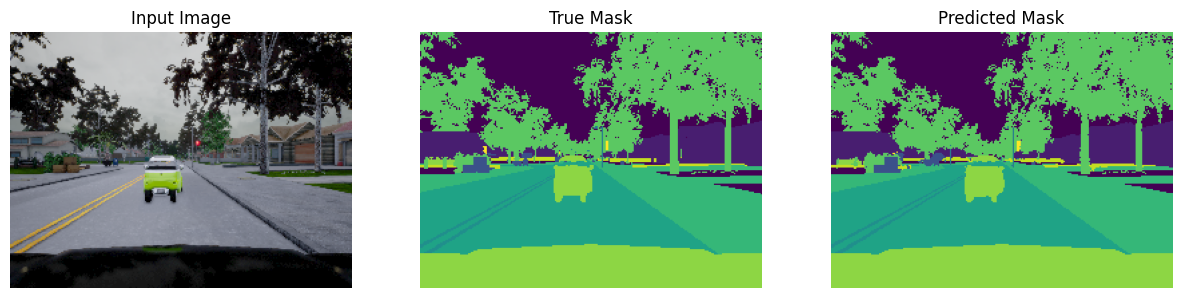

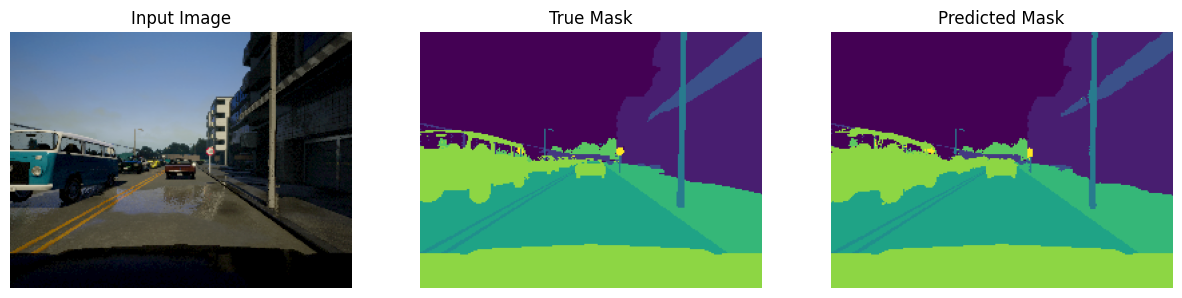

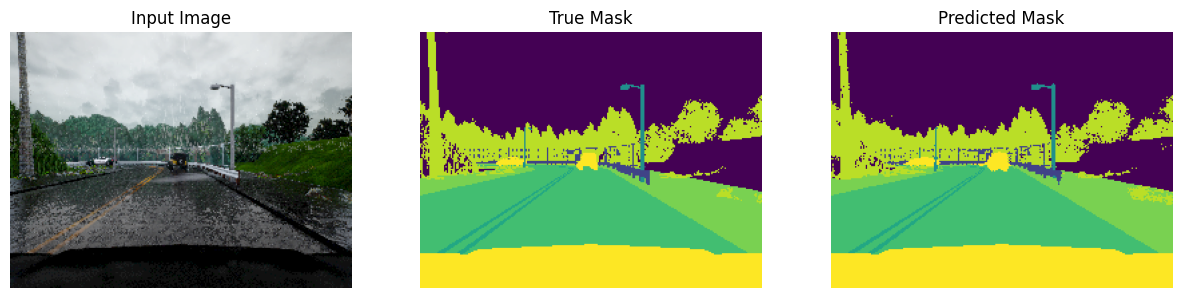

In [23]:
show_preds(unet_model, train_dataset, 3)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


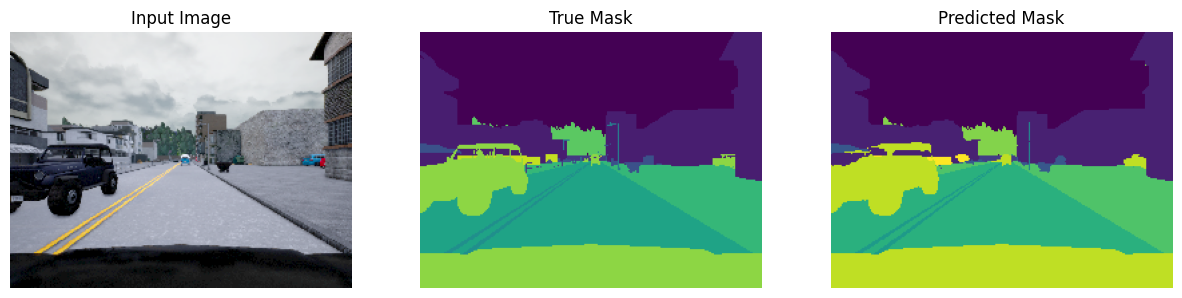

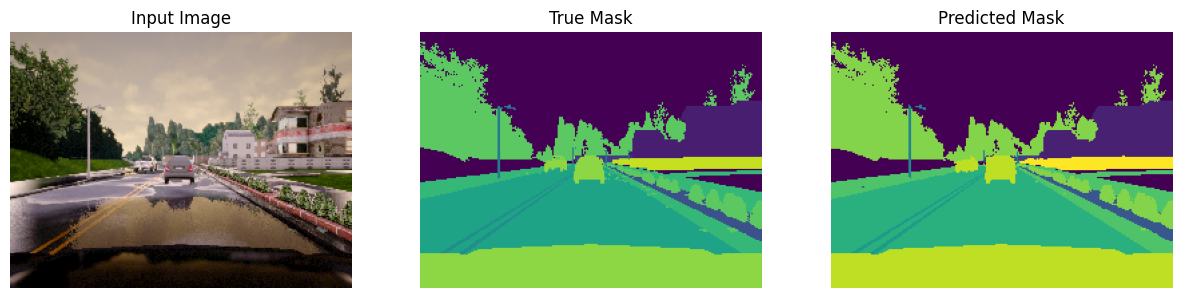

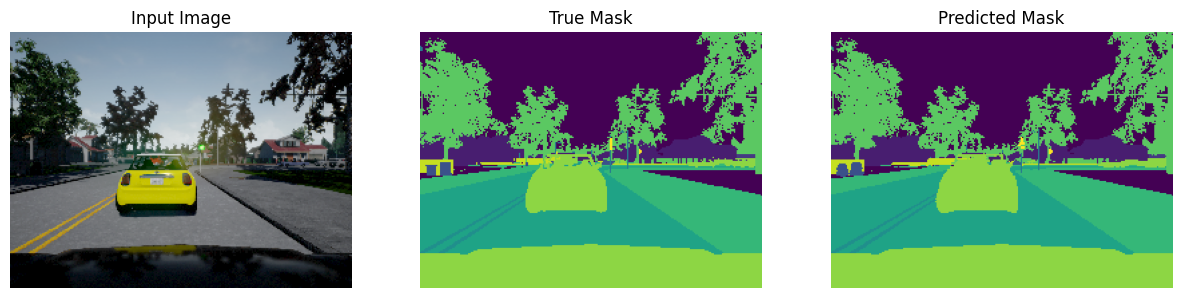

In [24]:
show_preds(unet_model, val_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


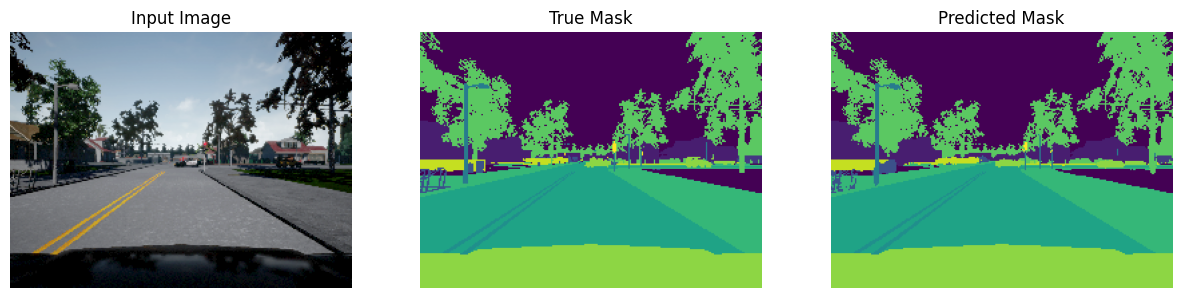

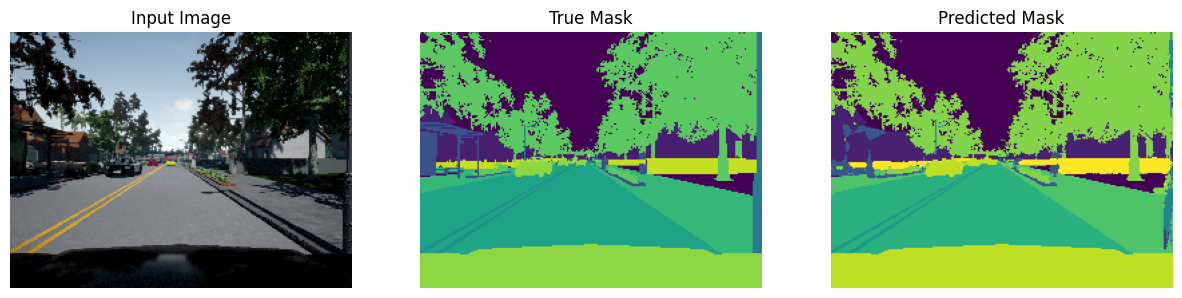

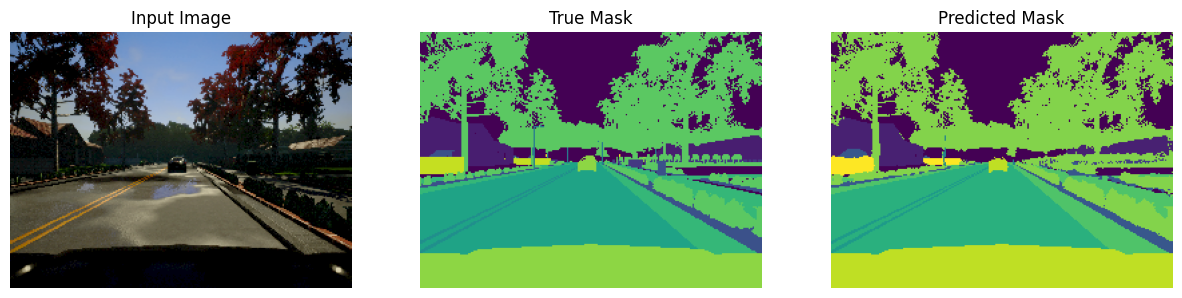

In [25]:
show_preds(unet_model, test_dataset)


In [26]:
def generate_mask(model, img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (192, 256), method = "nearest")
    
    sample_img = img[tf.newaxis, ...]
    pred_mask = model.predict(sample_img)
    pred_mask = create_mask(pred_mask)
    
    plt.figure(figsize = (10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
    plt.title('Sample Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[1:]))
    plt.axis('off')
    plt.title('Generated Mask')
    plt.plot()
    
    return img, pred_mask

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


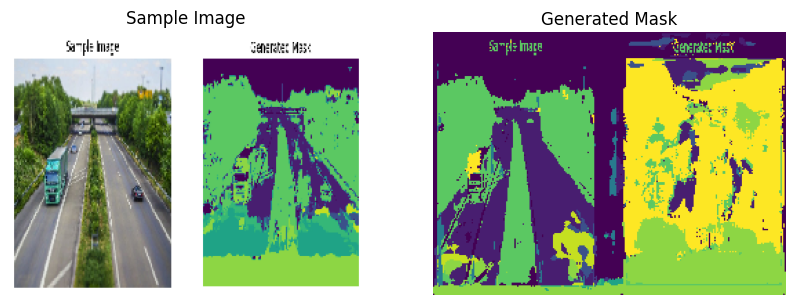

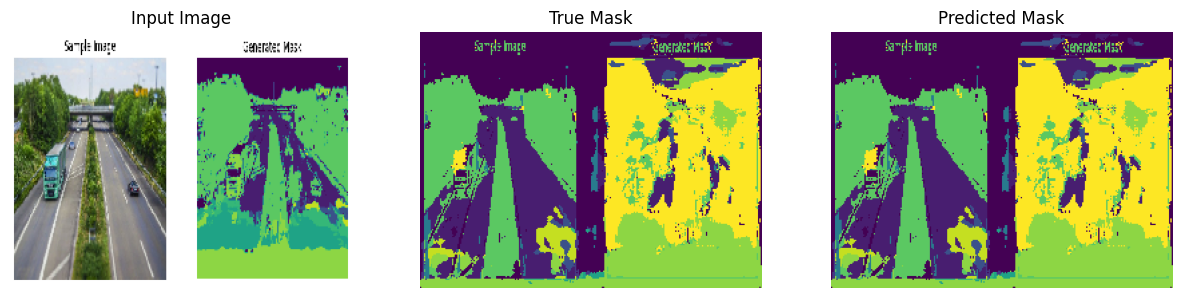

In [28]:
img, mask = generate_mask(unet_model, 'F:/SOC IMAGE SEGMENTATION/data/highway_road.png')

show_preds(unet_model, sample_image = img, sample_mask = mask) 
# The True and predicted mask will be the same as the mask is generated with the same model
